In [1]:
import os
import sys
sys.path.append('../codes')

import numpy as np

import cv2
import glob
from PIL import Image

import matplotlib.pyplot as plt

from utils.img_utils import add_bboxes_on_image

In [2]:
root_dir = "../data/data_aug/GAN"
img_dir = os.path.join(root_dir,"20231105_gan_1x", 'images' )
annot_dir = os.path.join(root_dir, "20231105_gan_1x", 'labels' )

In [3]:
list_imgs = glob.glob(os.path.join(img_dir, '**/*.png'), recursive=True)
img_idx = 0

In [4]:
list_imgs

['../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_0000.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_0024.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_0048.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_0072.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1032.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1056.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1080.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1416.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1440.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1464.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1488.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1512.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1536.png',
 '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1560.png',
 '../d

In [5]:
def get_bboxes(annot_path, img_width, img_height):    
    with open(annot_path, 'r') as marks:
        bboxes = {}    
        for mark in marks.readlines():                                                          
            rect = mark.replace('\n','').split('\t')          
#             objid,x,y,w,h = map(float,rect)
            
            objid,rcx,rcy,rw,rh = map(float,rect)
            x = int((rcx-rw/2)*img_width) 
            y = int((rcy-rh/2)*img_height)
            w = int(rw*img_width)
            h = int(rh*img_height)           
            
            bboxes[f'tire-{int(objid):02d}'] = [x, y, x+w, y+h]
        
    return bboxes

def get_img_size(datapath):
    img_pil = Image.open(datapath)
    width, height = img_pil.size
    return width, height
    

In [6]:
os.path.basename(list_imgs[img_idx])

'frame_0000.png'

0 ../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_0000.png
{'tire-00': [1124, 438, 1161, 471]}


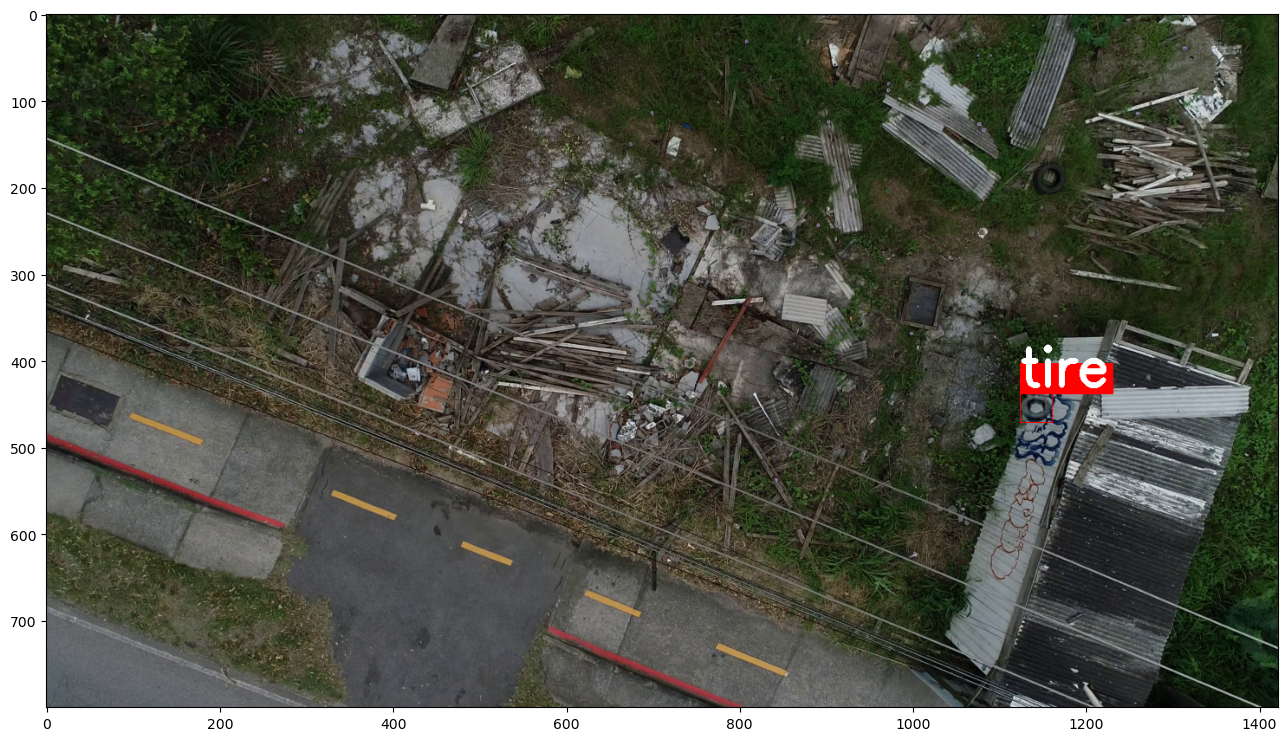

In [7]:
if img_idx >= len(list_imgs): img_idx = 0

img = cv2.imread(list_imgs[img_idx])[:,:,::-1]
img_h, img_w = img.shape[:2]

print(img_idx, list_imgs[img_idx])
annot_file = list_imgs[img_idx].replace('.png', '.txt').replace('images', 'labels')

bboxes = get_bboxes(annot_file, img_w, img_h)
print(bboxes)
        
plt.figure(figsize=(16,9))
img_bbox = add_bboxes_on_image(np.array(img), bboxes, color=(0, 0, 255), thickness=1)
plt.imshow(img_bbox)
plt.show()

img_idx += 1

In [8]:
from convert_mosquitoes_to_coco import Convert2Coco

In [9]:
coco_format = Convert2Coco()

In [10]:
for img_path in list_imgs:               
    annot_filepath = img_path.replace('images', 'labels').replace('.png', '.txt')
    
    w,h = get_img_size(img_path)
    bboxes = get_bboxes(annot_filepath, w, h)
    
    
    img_name = '/'.join(map(str, img_path.split('/')[-2:]))
    
    coco_format.update(img_name, w, h, bboxes)
    
    
coco_format.export(os.path.join(img_dir, 'gan_v0.json'))

In [11]:
from detectron2.data.datasets import load_coco_json, register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.structures.boxes import Boxes, BoxMode, pairwise_iou

import torch

In [12]:
dataset_name = 'ganV0'
register_coco_instances(dataset_name, {}, os.path.join(img_dir, 'gan_v0.json'), img_dir )

In [13]:
dataset = dataset_name
data = get_detection_dataset_dicts([dataset], filter_empty=True)


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [20]:
data[10]

{'file_name': '../data/data_aug/GAN/20231105_gan_1x/images/video06/frame_1488.png',
 'height': 800,
 'width': 1422,
 'image_id': 10,
 'annotations': [{'iscrowd': 0,
   'bbox': [1295.0, 644.0, 39.0, 33.0],
   'category_id': 0,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}

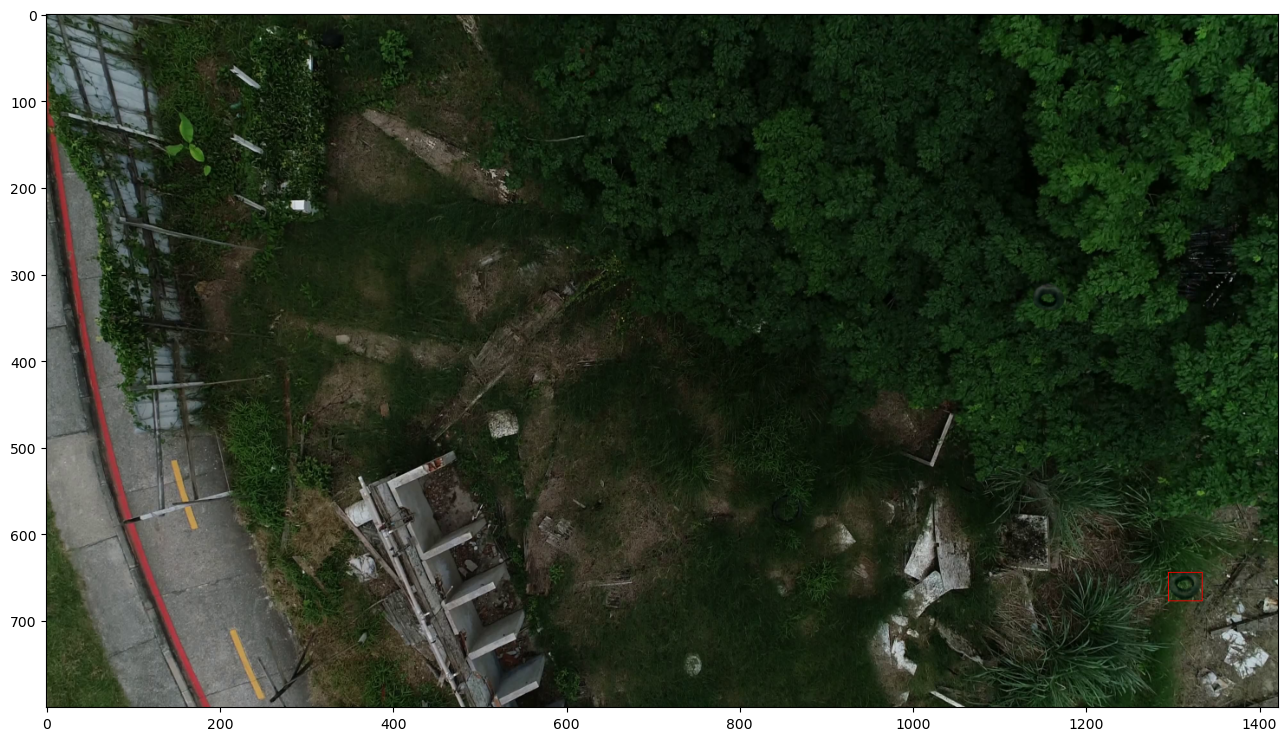

In [19]:
img_ind = 10
sample = data[img_ind]
        
img = Image.open(sample['file_name'])
targets = sample['annotations']
idx = sample['image_id']  

bbs_gt = (torch.tensor([d['bbox'] for d in targets])) 

if len(bbs_gt):
    bbs_gt = BoxMode.convert(bbs_gt, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
    img_bbox = add_bboxes_on_image(np.array(img), bbs_gt, color=(0, 0, 255), thickness=1)

# plot image
plt.figure(figsize=(16,9))
plt.imshow(img_bbox)
plt.show() 